# Lyric Mood Classification - Baselines

In this notebook, we establish baseline classification accuracies from several common classification strategies:
* Most-Common-Case
* Multinomial Naive-Bayes (NB)
* Support Vector Machines (SVM)

For each of the above, we baseline with several forms of input:
* Unequalized Moods
* Unequalized Mood Quadrants
* Equalized Moods
* Equalized Mood Quadrants

Where "unequalized" vs "equalized" refers to oversampling the under represented mood categories to create a more evenly distributed dataset and "quadrants" refers to grouping the categories into four quadrants to eliminate overlap between the moods.

We will use these baselines to compare to our CNN for mood classification.

In [2]:
# Project Imports
from label_lyrics import CSV_LABELED_LYRICS_EXPANDED
from mood_classification import build_lyrics_dataset, split_data, split_x_y

# Python and Package Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import WordPunctTokenizer, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [57]:
# Helpers
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

## Baselining Functions

Here we define functions for each classifier to be used in the following sections that vary based on form of data input.

In [58]:
def _most_common_case_accuracy(x, y):
    total_count = len(x)
    common_count = pd.Series(y).value_counts().max()
    accuracy = common_count / total_count
    return accuracy
    
def most_common_case_classification(df_train, df_dev, df_test):
    train_acc = _most_common_case_accuracy(df_train.lyrics_filename, df_train.mood) 
    dev_acc = _most_common_case_accuracy(df_dev.lyrics_filename, df_dev.mood)
    test_acc = _most_common_case_accuracy(df_test.lyrics_filename, df_test.mood)
    print('Most-Common-Case Classifier Train Accuracy:', pprint_accuracy(train_acc))
    print('Most-Common-Case Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    print('Most-Common-Case Classifier Test Accuracy:', pprint_accuracy(test_acc))


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def _prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

def prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics):
    # convert lyrics to counts and term-frequencies
    count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = _prep_lyrics_for_nb(train_lyrics)
    #print(x_train_tfidf.shape)
    _, x_dev_counts, _, x_dev_tfidf = _prep_lyrics_for_nb(dev_lyrics, count_vect, tfidf_transformer)
    #print(x_dev_tfidf.shape)
    _, x_test_counts, _, x_test_tfidf = _prep_lyrics_for_nb(test_lyrics, count_vect, tfidf_transformer)
    #print(x_test_tfidf.shape)
    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

def nb_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = MultinomialNB().fit(x_train_tfidf, y_train.astype('int')) 
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [60]:
def svm_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
                max_iter=5, tol=None).fit(x_train_tfidf, y_train.astype('int'))
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [61]:
def get_and_plot_x_y_data(quadrants, pad_data):
    print('building dataset')
    df = build_lyrics_dataset(
        CSV_LABELED_LYRICS_EXPANDED,
        word_tokenize,
        quadrants=quadrants,
        pad_data_flag=pad_data)

    print('plotting moods')
    _ = df.mood.value_counts().plot(kind='bar')

    print('splitting data')
    df_train, df_dev, df_test = split_data(df)
    x_train, y_train, x_dev, y_dev, x_test, y_test = split_x_y(
        df_train, df_dev, df_test, x_col='preprocessed_lyrics')

    print('***\nMost-Common-Case\n')
    most_common_case_classification(
        df_train,
        df_dev,
        df_test)
    print('***\nMultinomial Naive-Bayes\n')
    nb_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)
    print('***\nSupport Vector Machines\n')
    svm_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)


## Unequalized Moods


building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 40.07%
Most-Common-Case Classifier Dev Accuracy: 39.36%
Most-Common-Case Classifier Test Accuracy: 39.81%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 39.67%
Naive Bayes Classifier Test Accuracy: 39.93%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 45.41%
SVM Classifier Test Accuracy: 44.88%


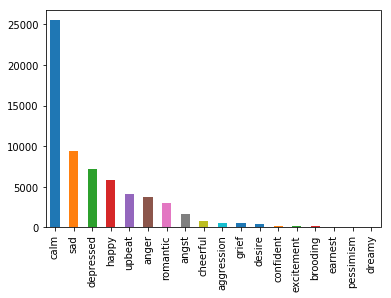

In [46]:
get_and_plot_x_y_data(quadrants=False, pad_data=False)

## Unequalized Moods Quadrants

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 42.87%
Most-Common-Case Classifier Dev Accuracy: 42.78%
Most-Common-Case Classifier Test Accuracy: 43.61%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 45.95%
Naive Bayes Classifier Test Accuracy: 46.78%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 51.29%
SVM Classifier Test Accuracy: 50.95%


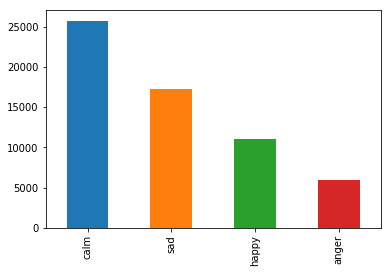

In [47]:
get_and_plot_x_y_data(quadrants=True, pad_data=False)

## Equalized Moods

In [ ]:
COL_LYRICS = 'lyrics'

print('building dataset')
df = build_lyrics_dataset(
    CSV_LABELED_LYRICS_EXPANDED,
    word_tokenize,
    quadrants=False,
    pad_data_flag=True,
    preprocess_col=COL_LYRICS,
    preprocess_padded_col='lyrics_')

print('plotting moods')
_ = df.mood.value_counts().plot(kind='bar')

In [44]:
from mood_classification import (import_lyrics_data, filter_lyrics_data, categorize_lyrics_data, pad_data,
    extract_lyrics_from_file, make_lyrics_txt_path)
lyrics_csv = CSV_LABELED_LYRICS_EXPANDED
word_tokenizer = word_tokenize
quadrants = False
pad_data_flag = True
preprocess_col = 'lyrics_pre'
preprocess_padded_col = 'lyrics_pre_pad'

# import, filter, and categorize the data
df = import_lyrics_data(lyrics_csv)

In [45]:

print('Data shape after import: {0}'.format(df.shape))
df = filter_lyrics_data(df, drop=True, quadrants=quadrants)
print('Data shape after filter: {0}'.format(df.shape))
df = categorize_lyrics_data(df)
print('Data shape after categorization: {0}'.format(df.shape))

# import the lyrics into the dataframe
# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics_from_file(make_lyrics_txt_path(x)))
print('Data shape after lyrics addition: {0}'.format(df.shape))
print('Df head:\n{0}'.format(df.lyrics.head()))

if pad_data_flag:
    print('Sampling and Padding data to balance data.')
    df = pad_data(df)



Data shape after import: (779056, 9)
Data shape after filter: (63803, 6)
Data shape after categorization: (63803, 7)
Data shape after lyrics addition: (63803, 8)
Df head:
3     And Oceans\nMiscellaneous\nNew Model World\n[i...
7     Electro eroticism\nIntelligence is sexy\nElect...
17    You fight just for the sake of it\nYou know wh...
19    I'm in the dark, I'd like to read his mind\nBu...
25    There was a time\nYou opened up every doorway\...
Name: lyrics, dtype: object
Sampling and Padding data to balance data.


In [46]:
from mood_classification import compute_lyrics_cutoff, preprocess_lyrics
import time
# preprocess the lyrics
print('Beginning Preprocessing of Lyrics... (this might take a couple minutes)')
start = time.time()
cutoff = compute_lyrics_cutoff(df)
df[preprocess_col] = df.lyrics.apply(
    lambda x: preprocess_lyrics(x, word_tokenizer, do_padding=False, cutoff=cutoff)) 
#df[preprocess_padded_col] = df.lyrics.apply(
#    lambda x: preprocess_lyrics(x, word_tokenizer, do_padding=True, cutoff=cutoff)) 
print('Preprocessing completed')
print('dropping df.lyrics')
df.drop('lyrics', axis=1)
print((time.time() - start) / 60)


Beginning Preprocessing of Lyrics... (this might take a couple minutes)
Preprocessing completed
dropping df.lyrics
10.270196731885274


In [48]:
print('splitting data')
df_train, df_dev, df_test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])
print('df split')
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)
#df_train, df_dev, df_test = split_data(df)
x_train, y_train, x_dev, y_dev, x_test, y_test = split_x_y(
    df_train, df_dev, df_test, x_col=preprocess_col)
print('xy split')
print(x_train.shape)
print(y_train.shape)
print(x_dev.shape)
print(y_dev.shape)
print(x_test.shape)
print(y_test.shape)


splitting data
df split
(367228, 9)
(45904, 9)
(45904, 9)
xy split
(367228,)
(367228, 18)
(45904,)
(45904, 18)
(45904,)
(45904, 18)


In [49]:
print('***\nMost-Common-Case\n')
most_common_case_classification(
    df_train,
    df_dev,
    df_test)



***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.58%
Most-Common-Case Classifier Dev Accuracy: 5.70%
Most-Common-Case Classifier Test Accuracy: 5.68%


In [53]:

def _prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

def prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics):
    # convert lyrics to counts and term-frequencies
    count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = _prep_lyrics_for_nb(train_lyrics)
    #print(x_train_tfidf.shape)
    _, x_dev_counts, _, x_dev_tfidf = _prep_lyrics_for_nb(dev_lyrics, count_vect, tfidf_transformer)
    #print(x_dev_tfidf.shape)
    _, x_test_counts, _, x_test_tfidf = _prep_lyrics_for_nb(test_lyrics, count_vect, tfidf_transformer)
    #print(x_test_tfidf.shape)
    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

train_lyrics = df_train.lyrics
y_train = df_train.mood_cats
dev_lyrics = df_dev.lyrics
y_dev = df_dev.mood_cats
test_lyrics = df_test.lyrics
y_test = df_test.mood_cats

x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)


In [54]:
y_test

68775      8
128652    15
458501    11
414959    17
111530    15
43597      4
129546    15
146017    10
263311    14
266691    14
279720     5
428756    17
78791      8
440822    11
222583     2
33033      4
194689     0
349772     9
307857     6
386156     3
328249     7
9790       4
264535    14
35159      7
137242    10
165921     1
346201     9
375679     3
71363      8
232752    12
          ..
295660     5
72233      8
312684     6
167786     1
84227      8
175657     1
233753    12
302038     6
32434      2
8346      16
366832     9
178307     0
410214    16
399260    16
375202     3
394332     3
429329    17
434473    11
361775     9
168521     1
292508     5
322156     6
190646     0
22514      4
104457    13
46218     13
96003     13
407671    16
178745     0
187082     0
Name: mood_cats, Length: 45904, dtype: object

In [56]:
clf = MultinomialNB().fit(x_train_tfidf, y_train.astype('int')) 
dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 74.52%
Naive Bayes Classifier Test Accuracy: 74.68%


In [62]:
print('***\nMultinomial Naive-Bayes\n')
nb_classification(
    df_train.lyrics, df_train.mood_cats,
    df_dev.lyrics, df_dev.mood_cats,
    df_test.lyrics, df_test.mood_cats)


***
Multinomial Naive-Bayes



ValueError: Unknown label type: (array([15, 9, 6, ..., 10, 0, 5], dtype=object),)

In [ ]:
print('***\nSupport Vector Machines\n')
svm_classification(
    df_train.lyrics, df_train.mood_cats,
    df_dev.lyrics, df_dev.mood_cats,
    df_test.lyrics, df_test.mood_cats)

In [8]:
train_lyrics = df_train.lyrics
y_train = df_train.mood_cats
dev_lyrics = df_dev.lyrics
y_dev = df_dev.mood_cats
test_lyrics = df_test.lyrics
y_test = df_test

x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)


MemoryError: 

In [36]:

clf = MultinomialNB().fit(x_train_tfidf, y_train) 
dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 74.89%


ValueError: invalid literal for int() with base 10: 'Sean_Lennon___Parachute'

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.60%
Most-Common-Case Classifier Dev Accuracy: 5.75%
Most-Common-Case Classifier Test Accuracy: 5.71%
***
Multinomial Naive-Bayes



ValueError: Unknown label type: (array([8, 5, 6, ..., 14, 0, 14], dtype=object),)

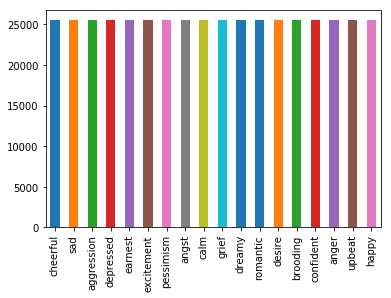

In [12]:
get_and_plot_x_y_data(quadrants=False, pad_data=True)

## Equalized Mood Quadrants

In [ ]:
get_and_plot_x_y_data(quadrants=True, pad_data=True)